Notebook to illustrate simple ways to display / characterize data

In [1]:
%matplotlib inline 
import numpy as np
import astropy.time
import astropy.units as u
from astropy import constants as const
import dateutil.parser
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import astropy.io.ascii
from plots import fontsize, fig_width
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation
from scipy.interpolate import interp1d

In [2]:
xsec_pp = 4e-26 # proton-prorton x-section in cm^-2
xsec_pg = 4e-28 # proton-gamma at delta resonance
xsec_xe = 6.7e-25 # x-rays - electrons 
k_b = 1.381e-23 # J/K
sigma_b = 5.67e-12 # W/cm2/K4

discovery_d = dateutil.parser.parse('2019.04.09')
time = astropy.time.Time(discovery_d)

Schwarzschild Radius8.9e+12


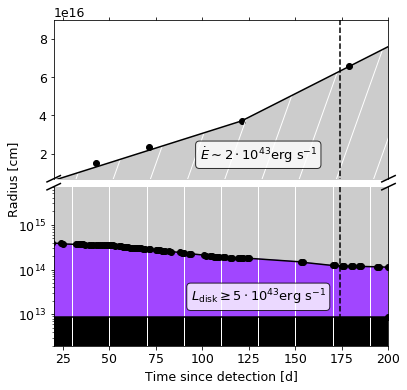

In [3]:
dates = []
flux_max=np.array([0.4, 0.7, 2., 2.])
freq_max=np.array([10,10,10,6])

#dt = dateutil.parser.parse('2019.10.01')
time_discovery = astropy.time.Time(time)


obs_dates = ['2019.05.22','2019.06.19','2019.08.08','2019.10.05']
#r_eq = [1.62e16, 2.5e16,4.06e16, 6.62e16]
r_eq = [pow(10,16.18), pow(10,16.37), pow(10,16.57), pow(10,16.82)]

for obs in obs_dates:

    time = [] 
    dt = dateutil.parser.parse(obs)
    time = astropy.time.Time(dt)
    dates.append(time.jd-time_discovery.jd)


nu_day=174

fig = plt.figure(figsize=(fig_width, fig_width))

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)


ax1 = fig.add_subplot(2, 1, 1)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylim([7e15,0.9e17])


plt.plot(dates,r_eq,'o', color='black')


#plt.plot([1, 2, 3, 4])

ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
ax2.set_yscale('log')

ax1.set_ylabel('Radius [cm]',size =fontsize)
ax2.set_xlabel('Time since detection [d]', size =fontsize)

x = np.linspace(30., 190., 30)

#ax2.plot(x, x * 3.e10 *24 *3600. * 0.08 + 4e15, color='0.5', ls='dashed')
plt.ylim([2e12, 7e15])

x2 = np.linspace(150., 180., 30)


ax2.plot(x2, 150 * 3.e10 *24 *3600. * 0.08 + 4e15 + (x2-150) * 3.e10 *24 *3600. * 0.2  , color='0.5')

# the photospheres

r_bb=1e14
r_pg=r_bb
days=np.arange(0,200,1)
#ax2.fill_between(days, 0, r_pg, color='orange')
#ax2.fill_between(days, 0, r_bb, color='red')

# the jets

lw=1
offset=0.5

for x in range(0, 20):
    radius = 1e17
    c_light = 3.15e10 * 3600. *24. # speed of light in cm per day 
    step = 20    
    offs = 0
    if x>5:
        step =20
        offs = 0
    
    
    day_start = x * step + 10 + offs
    day_end = x * step + 10 + radius / c_light + offs

    ax1.plot([day_start-offset, day_end-offset], [1, radius], 'k-',linewidth=lw, color='white')
    ax2.plot([day_start, day_start], [1, radius], 'k-', linewidth=lw,color = 'white')


# radio boundary
d1 = 0
r1 = 0
d2 = dates[2]
r2 = r_eq[2]
d3 = 200
r3 = r_eq[3]*1.15

ax1.plot([d1, d2], [r1, r2], 'k-')
ax1.plot([d2, d3], [r2, r3], 'k-')

grey_colour = "0.8"

ax1.fill_between([d1, d3], [r1, r3]    , [1e18, 1e18], color='white',alpha=1)
ax2.fill_between([d1, d3], [r_pg, r_pg], [1e18,1e18], color=grey_colour)
ax1.fill_between([d1, d2], 0 , [r1, r2], color=grey_colour)
ax1.fill_between([d2, d3], 0 , [r2, r3], color=grey_colour)

# the neutrino
ax2.plot([nu_day, nu_day], [1, 2e17], 'k--')
ax1.plot([nu_day, nu_day], [1, 2e17], 'k--')

# labels
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

x_for_text = 130.

ax1.text(x_for_text, 1.7e16, r'$\dot{E} \sim 2 \cdot 10^{43} \rm erg~s^{-1}$', fontsize=13, bbox=props, ha='center')
ax2.text(x_for_text, 2e13, r'$L_{\rm disk} \geq 5 \cdot 10^{43} \rm erg~s^{-1}$', fontsize=13, bbox=props, ha='center')

d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# next comes the BB radius 

data = astropy.io.ascii.read('data/BranStark_RT.dat.txt')
rad_bb = pow(10,data['R_cm'])
t_bb = pow(10,data['T_K'])


e_g = 2.7 * k_b * t_bb 

# next comes the nu-proton interaction radius 
optical_lumi = sigma_b * 3.14 * pow(rad_bb,2)*pow(t_bb,4)
r_pg= optical_lumi/e_g/4/3.14/3e10*xsec_pg

t0=58582.920894 # first observation

#ax2.plot(data['MJD']-t0,r_pg,'o-', color='black')
#ax2.fill_between(data['MJD']-t0,r_pg,color='orange')
ax2.plot(data['MJD']-t0,rad_bb,'o-', color='black')
ax2.fill_between(data['MJD']-t0,rad_bb,color='#A146FF')

r_s = (2. * const.G * const.M_sun * (3 * 10**7)/const.c**2).to("cm").value
print(f"Schwarzschild Radius{r_s:.2g}")

ax2.plot([0,200],[r_s,r_s],'o-', color='black')
ax2.fill_between([0,200],[r_s, r_s],color='black')


#plt.set_xlabel('Time since detection (s)')
#plt.set_ylabel('Temperature (K)')

# merge the two graphs
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax1.yaxis.set_label_coords(-0.1,0)
plt.subplots_adjust(wspace=0, hspace=0.05)
plt.xlim([20, 200])


plt.savefig('plots/rad_vs_time_bran.pdf')
plt.show()


In [110]:
dates = []
flux_max=np.array([0.4, 0.7, 2., 2.])
freq_max=np.array([10,10,10,6])

dt = dateutil.parser.parse('2019.04.09')
time_discovery = astropy.time.Time(dt)


obs_dates = ['2019.05.22','2019.06.19','2019.08.08','2019.10.05']
#r_eq = [1.62e16, 2.5e16,4.06e16, 6.62e16]
r_eq = np.array([pow(10,16.18), pow(10,16.37), pow(10,16.57), pow(10,16.82)])

for obs in obs_dates:

    time = [] 
    dt = dateutil.parser.parse(obs)
    time = astropy.time.Time(dt)
    dates.append(time.jd-time_discovery.jd)


nu_day=174

dates = np.array(dates)

# next comes the BB radius 

data = astropy.io.ascii.read('data/BranStark_RT.dat.txt')
rad_bb = pow(10,data['R_cm'])
t_bb = pow(10,data['T_K'])


e_g = 2.7 * k_b * t_bb 

# next comes the nu-proton interaction radius 
optical_lumi = sigma_b * 3.14 * pow(rad_bb,2)*pow(t_bb,4)
r_pg= optical_lumi/e_g/4/3.14/3e10*xsec_pg

x = [-100.0] + list(data["MJD"] - time_discovery.mjd) + [1001.]

y = [rad_bb[0]] + list(rad_bb) + [rad_bb[-1]]

f = interp1d(x, y)

print(np.log10(f(30.), f(30.)))

14.564200735046922


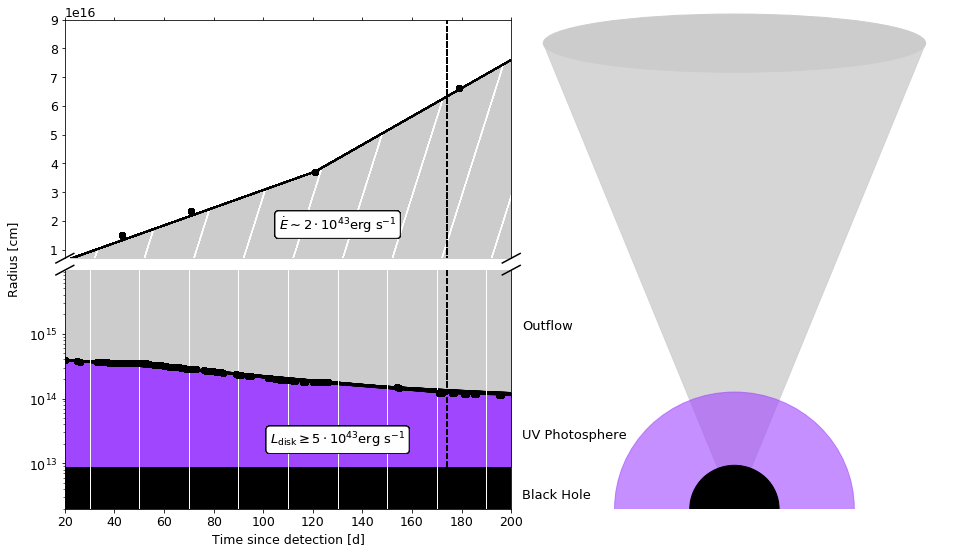

In [113]:
frames=100

scale1=300/frames

scale2 = 10/frames

fig = plt.figure(figsize=(16, 9))

plt.rc('font', family='sans-serif')
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)


ax1a = fig.add_subplot(2, 2, 1)
ax2 = plt.subplot(122)
plt.setp(ax1a.get_xticklabels(), visible=False)

ax1a_lims = [7e15,0.9e17]

ax1a.set_ylim(ax1a_lims)

ax1b = fig.add_subplot(2, 2, 3, sharex=ax1a)
ax1b.set_yscale('log')

ax1a.set_ylabel('Radius [cm]',size =fontsize)
ax1b.set_xlabel('Time since detection [d]', size =fontsize)

x = np.linspace(30., 190., 30)

#ax2.plot(x, x * 3.e10 *24 *3600. * 0.08 + 4e15, color='0.5', ls='dashed')
ax1b_lims = [2e12, 9.5e15]
ax1b.set_ylim(ax1b_lims)

# x2 = np.linspace(150., 180., 30)

# ax1b.plot(x2, 150 * 3.e10 *24 *3600. * 0.08 + 4e15 + (x2-150) * 3.e10 *24 *3600. * 0.2  , color='0.5')

# the photospheres

r_bb=1e14
r_pg=r_bb
days=np.arange(0,200,1)


# the jets

lw=1
offset=0.5


# radio boundary
d1 = 0
r1 = 0
d2 = dates[2]
r2 = r_eq[2]
d3 = 200
r3 = r_eq[3]*1.15

grad_1 = (r2-r1)/(d2-d1)
c_1 = r2 - grad_1 * d2

def radio_rad_1(t):
    return grad_1 * t + c_1

grad_2 = (r3-r2)/(d3-d2)
c_2 = r3 - grad_2 * d3

def radio_rad_2(t):
    return grad_2 * t + c_2

# ax1a.plot([d1, d2], [r1, r2], 'k-', alpha=0.3)
# ax1a.plot([d2, d3], [r2, r3], 'k-')

# grey_colour = "0.8"

# ax1a.fill_between([d1, d3], [r1, r3]    , [1e18, 1e18], color='white',alpha=1)
# ax1b.fill_between([d1, d3], [r_pg, r_pg], [1e18,1e18], color=grey_colour, alpha=0.3)
# ax1a.fill_between([d1, d2], 0 , [r1, r2], color=grey_colour, alpha=0.3)
# ax1a.fill_between([d2, d3], 0 , [r2, r3], color=grey_colour, alpha=0.3)

# labels

d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1a.transAxes, color='k', clip_on=False)
ax1a.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1a.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax1b.transAxes)  # switch to the bottom axes
ax1a.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax1b.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

r_s = (2. * const.G * const.M_sun * (3 * 10**7)/const.c**2).to("cm").value


# merge the two graphs
ax1a.spines['bottom'].set_visible(False)
ax1b.spines['top'].set_visible(False)
ax1a.xaxis.tick_top()
ax1a.tick_params(labeltop=False)  # don't put tick labels at the top
ax1b.xaxis.tick_bottom()

ax1a.yaxis.set_label_coords(-0.1,0)
plt.subplots_adjust(wspace=0, hspace=0.05)
plt.xlim([20, 200])

def make_artists(y):

    tri = [[0,0], [-y/2.5,y], [y/2.5, y]]
        
    ell = ((0, y), 0.8*y, y/8)
    
    return tri, ell

def r_plot_uv(r_uv):
    return 4.5* ((np.log(r_uv) - np.log(ax1b_lims[0]))/(np.log(ax1b_lims[1]) - np.log(ax1b_lims[0])))

# ax.tick_params(axis='both', which='major', labelsize=12, colors="white")
# plt.grid()
ax2.set_xlim(-4, 4)
ax2.set_ylim(0, 9)
ax2.axison = False

uv = plt.Circle((0,0), r_plot_uv(f(20.)), color='#A146FF', alpha=0.6)
ax2.add_artist(uv)

bh = plt.Circle((0,0),0.8, color="black")
ax2.add_artist(bh)

tri, ell = make_artists(4.5)

t1 = plt.Polygon(tri, color=grey_colour, alpha=0.8)
ax2.add_patch(t1)

e1 = Ellipse(ell[0], width=ell[1], height=ell[2], color=grey_colour)
ax2.add_patch(e1)

label = False

def update_plot(j):
    
    ndays = j * scale1
    
    
    # Left plot
    
    if ndays > nu_day:
        
        # the neutrino
        ax1b.plot([nu_day, nu_day], [1, 2e17], 'k--', zorder=4)
        ax1a.plot([nu_day, nu_day], [1, 2e17], 'k--', zorder=4)
                            
    if ndays < d2:
                
        r_radio = radio_rad_1(ndays)
        
        ax1a.plot([d1, ndays], [r1, r_radio], 'k-', zorder=4)
        ax1a.fill_between([d1, ndays], [r1, r_radio], [1e15, 1e15], color=grey_colour,alpha=1)
        
    else:
        
        r_radio = radio_rad_2(ndays)
        
        ax1a.plot([d1, d2], [r1, r2], 'k-', zorder=4)
        ax1a.fill_between([d1, d2], [r1, r2], [1e15, 1e15], color=grey_colour,alpha=1)
        
        ax1a.plot([d2, ndays], [r2, r_radio], 'k-', zorder=4)
        ax1a.fill_between([d2, ndays], [r2, r_radio], [1e15, 1e15], color=grey_colour,alpha=1)
        
    mask = (data['MJD']- time_discovery.mjd) < ndays
    
    if np.sum(mask) > 0:
        ax1b.plot(data['MJD'][mask]- time_discovery.mjd, rad_bb[mask], 'o', color='black', zorder=4)
        
    
    mask = dates < ndays
    
    if np.sum(mask) > 0:

        ax1a.plot(dates[mask], r_eq[mask], 'o', color='black')
        
    if ndays > 20.:
        
        ax1b.fill_between([0., ndays], [1.e12, 1.e12], [1.e16, 1.e16], color=grey_colour)

        t_range = np.linspace(20., ndays, 5)
        ax1b.plot(t_range, f(t_range), color='k')
        ax1b.fill_between(t_range, f(t_range), r_s * np.ones_like(t_range), color='#A146FF')

        r_uv = f(ndays)

        ax1b.fill_between([0, ndays],[r_s, r_s],color='black')
        
        for x in range(0, 20):
            radius = 1e17
            c_light = 3.15e10 * 3600. *24. # speed of light in cm per day 
            step = 20    
            offs = 0
            if x>5:
                step =20
                offs = 0

            day_start = x * step + 10 + offs
            day_end = x * step + 10 + radius / c_light + offs

            ax1a.plot([day_start-offset, day_end-offset], [1, radius], 'k-',linewidth=lw, color='white')
            ax1b.plot([day_start, day_start], [1, radius], 'k-', linewidth=lw,color = 'white')
        

    # ax1a.plot([d2, d3], [r2, r3], 'k-')

    # grey_colour = "0.8"

    #     ax1b.fill_between([d1, d3], [r_pg, r_pg], [1e18,1e18], color=grey_colour, alpha=0.3)
    #     ax1a.fill_between([d1, d2], 0 , [r1, r2], color=grey_colour, alpha=0.3)
    #     ax1a.fill_between([d2, d3], 0 , [r2, r3], color=grey_colour, alpha=0.3)

    #     if j < 0.8 * frames:


        # Right Plot


        if ndays < 200:

            [p.remove() for p in reversed(ax2.patches)]
            [p.remove() for p in reversed(ax2.artists)]

            r_outflow = 4.5* (1. + r_radio/(ax1a_lims[1] - ax1a_lims[0]))

            tri, ell = make_artists(r_outflow)

            t1 = plt.Polygon(tri, color=grey_colour, alpha=0.8)
            ax2.add_patch(t1)

            e1 = Ellipse(ell[0], width=ell[1], height=ell[2], color=grey_colour, clip_on=False)
            ax2.add_patch(e1)

    #         r_plot_uv = 4.5* ((np.log(r_uv) - np.log(ax1b_lims[0]))/(np.log(ax1b_lims[1]) - np.log(ax1b_lims[0])))

            uv = plt.Circle((0,0), r_plot_uv(r_uv), color='#A146FF', alpha=0.6)
            ax2.add_artist(uv)

            bh = plt.Circle((0,0),0.8, color="black")
            ax2.add_artist(bh)
            
        else:
            alpha = 0.8
            
            props = dict(boxstyle='round', facecolor='white', alpha=alpha)
            
            x_for_text = 130.
            

            
            if j < (0.80 * frames):
                   
                [p.remove() for p in reversed(ax2.texts)]

                ax2.text(-3.8, 0.2, "Black Hole", fontsize=13, ha='left')
                ax2.text(-3.8, 1.3, "UV Photosphere", fontsize=13, ha='left')
                ax2.text(-3.8, 3.3, "Outflow", fontsize=13, ha='left')

            else:
                ax1a.text(x_for_text, 1.7e16, r'$\dot{E} \sim 2 \cdot 10^{43} \rm erg~s^{-1}$', fontsize=13, bbox=props, ha='center')
                ax1b.text(x_for_text, 2e13, r'$L_{\rm disk} \geq 5 \cdot 10^{43} \rm erg~s^{-1}$', fontsize=13, bbox=props, ha='center')
            

ani = FuncAnimation(fig, update_plot, frames=frames, interval=30,
                    blit=False)
ani.save("plots/outflow_through_time.mp4")
plt.savefig("plots/outflow_schematic.pdf")

In [6]:
# magnetic energy
EB=pow(B,2)*pow(R,3)/6
EB=2.1 * 1E46(pow(F,−4) * pow(d,−8) pow(nu,10) * (1+z)*14)*pow(R17,11) # R17 in units of 10^17 cm, nu in 10 GhZ, d

SyntaxError: invalid character in identifier (<ipython-input-6-2eaff7884cee>, line 3)

In [ ]:
print(data.T.columns[1])

In [ ]:
# magnetic fields according to 1304.1543
freq_max=np.array([10,10,10,6])
flux_max=np.array([0.4, 0.7, 2., 2.])




nu_peak10 = freq_max[3] / 10. # 5 Ghz

nu_peak5 = freq_max[3] / 5. # 5 Ghz
f_peak=flux_max[3]
dl_28=d_l / 100.
fa=1
R17=0.5
Gamma=1
print(d_l)
d_mpc=220

R17= 1.7 * pow(f_peak,8/17)*pow(1+z,-25/17)/nu_peak10*pow(dl_28,16/17)*pow(fa,-7/17)*pow(Gamma,10/17) #Gauss
print("radius:",R17) # units of 1E17 cm

B = 1.3E-2 * pow(f_peak,5)*pow(1+z,7)/pow(nu_peak10,2)*pow(dl_28,-4)*pow(fa,2)*pow(R17,-4)/pow(Gamma,3) #Gauss
print("mag field", B)

# magnetic field accordint to Chevalier 1998

R15= 8.8 * pow(f_peak/1000.,9/19)/nu_peak5*pow(d_mpc,18/19)*pow(fa,-7/17)*pow(Gamma,10/17) #Gauss
print("Radius:",R15) # units of 1E15 cm

B= 0.58 * pow(f_peak/1000.,-2/19)*nu_peak5*pow(d_mpc,-4/19)*pow(fa,-7/17)*pow(Gamma,10/17) #Gauss
print("magnetic field in G:",B) # units of 1E15 cm

# Hillas 1984:  The Origin of Ultra-High-Energy Cosmic Rays, Annual Review of Astronomy and Astrophysics

Ep20 = B*R15*1e15/3/1e17  
print("Max proton Energy:", Ep20)


In [ ]:
print(d_l)

In [ ]:
#import numpy as np
#import matplotlib.pyplot as plt

#from astropy.modeling import models
#from astropy.modeling.models import BlackBody
#from astropy import units as u
#from astropy.visualization import quantity_support

#bb = BlackBody(temperature=5778*u.K)
#wav = np.arange(1000, 110000) * u.AA
#flux = bb(wav)

#with quantity_support():
#    plt.figure()
#    plt.semilogx(wav, flux)
#    plt.axvline(bb.nu_max.to(u.AA, equivalencies=u.spectral()).value, ls='--')
#    plt.show()

In [ ]:
epsilon_b = 100 
f_a=0.1

energy = 8e48 * pow(epsilon_b,11/16)* pow(f_a,-12/19)# in erg
energy_100tev =  energy * 0.66 / 100 # now its in units of 100 TeV, since 1erg = 0.66 TeV 
dist = 220*3.08568*1e24 # in cm
A_s =  4*3.14*pow(dist,2) 
A_eff = 100 * 1e4 # IC eff area at 100 TeV = 100 m2, expressed in cm2
print("kin energy", energy)
print("fluence",energy/A_s)


print("Neutrino events:",energy_100tev*A_eff/A_s*0.25/2) 
print("energy per 4 month per cm2:",energy/A_s/1e7) 




In [ ]:
#Cross section

xsec_pp = 4e-26 # proton-prorton x-section in cm^-2
xsec_pg = 4e-28 # proton-gamma at delta resonance
xsec_xe = 6.7e-25 # x-rays - electrons 

r_0=6e16
r_bb = pow(10,14.1) #  not used anymore
t_bb = pow(10,4.65)#  not used anymore
sigma_b = 5.67e-12 # W/cm2/K4
k_b = 1.381e-23 # J/K
e_g = 2.7 * k_b * t_bb 

r_dens = 1e16 # normalization for density
g_dens = -2.5 # power law index for radius scaling r^g_dens
dens = 1e9 # cm^-3 @ r_dens cm

column_density = dens* r_dens * -1 * (g_dens+1) * pow(r_0/r_dens,g_dens+1)

sigma_b = 5.67e-12 # W/cm2/K4
e_g = 2.7 * k_b * t_bb 
optical_lumi = sigma_b * 3.14 * pow(r_bb,2)*pow(t_bb,4)
photon_density = optical_lumi/e_g/4/3.14/pow(r_0,2)/3e10
r_pg= optical_lumi/e_g/4/3.14/3e10*xsec_pg

print(r_pg/1e14)

print("optical depth - pp = ",column_density * xsec_pp)
print("optical depth - xe = ",column_density * xsec_xe)



print("optical depth - pg:",photon_density*xsec_pg*r_0) 
print("Optical lum:",optical_lumi*1e7) # in erg = 1e-7Ws
print("Number of photons:",optical_lumi/k_b/t_bb) 
print("photon density:",photon_density) 
print("Temperature:",t_bb)







In [ ]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0.01, 5.0, 0.01)
s1 = np.sin(2 * np.pi * t)
s2 = np.exp(-t)
s3 = np.sin(4 * np.pi * t)

ax1 = plt.subplot(311)
plt.plot(t, s1)
plt.setp(ax1.get_xticklabels(), fontsize=6)

# share x only
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(t, s2)
# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=False)

# share x and y
ax3 = plt.subplot(313, sharex=ax1, sharey=ax1)
plt.plot(t, s3)
plt.xlim(0.01, 5.0)
plt.show()


In [ ]:
b=0.7
gamma=b/pow(1-b*b,0.5)
print(gamma)

a=pow(3.5,19/8)
print(a)

In [ ]:
%matplotlib inline 
import numpy as np
import astropy.time
import astropy.units as u
import dateutil.parser
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from astropy.cosmology import WMAP9 as cosmo

discovery_d = dateutil.parser.parse('2019.04.09')
time = astropy.time.Time(discovery_d)

dates = []
flux_max=np.array([0.4, 0.7, 2., 2.])
freq_max=np.array([10,10,10,6])

#dt = dateutil.parser.parse('2019.10.01')
time_discovery = astropy.time.Time(time)


obs_dates = ['2019.05.22','2019.06.19','2019.08.08','2019.10.05']

for obs in obs_dates:

    time = [] 
    dt = dateutil.parser.parse(obs)
    time = astropy.time.Time(dt)
    dates.append(time.jd-time_discovery.jd)

Mpctocm_26 = 3.086e-2
z=0.05
d_l = cosmo.luminosity_distance(z) / u.Mpc * Mpctocm_26
print(pow(d_l,18/19.))
f_a = 1.
f_v = 1.

r_eq = 3.2e15 * pow(flux_max,9./19.) * pow(d_l,18/19.) * pow(freq_max,-1.) * 10. * (1+z) * pow(f_a,-8./19)*pow(f_v,-1/19.)

fig = plt.figure(figsize=(4, 3))


plt.rc('font', family='serif')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')


fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
plt.plot(dates,r_eq,'o', color='black')


#plt.plot([1, 2, 3, 4])
ax.set_xlabel('Time since detection [d]', size = 'large')
ax.set_ylabel('Radius [cm]',size = 'large')


x = np.linspace(30., 190., 30)

ax.plot(x, x * 3.e10 *24 *3600. * 0.08 + 4e15, color='0.5', ls='dashed')

x2 = np.linspace(150., 180., 30)


ax.plot(x2, 150 * 3.e10 *24 *3600. * 0.08 + 4e15 + (x2-150) * 3.e10 *24 *3600. * 0.2  , color='0.5')


#plt.set_xlabel('Time since detection (s)')
#plt.set_ylabel('Temperature (K)')

plt.savefig('rad_vs_time_bran.png')

plt.show()

print(r_eq)
v = r_eq/86400./50./1e5 /3.e5 # in units of c
print(3.0e12)
print(v)
print(1/pow((1-pow(v,2)),0.5))